In [1]:
import os
import torch
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn

import sys
sys.path.append('../src/data')
sys.path.append('..')

from datasets import CelebaDataset, WFLWDataset
import landmark_transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

In [2]:
data_loc = '/home/data/celeba/'
wflw_data_loc = '/home/data/wflw/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(transforms.ToPILImage()(image))
    plt.scatter(landmarks[:, 0] * image.shape[-1], landmarks[:, 1] * image.shape[-2], s=5, marker='.', c='b')
    plt.pause(0.001)  # pause a bit so that plots are updated

# WFLW

In [13]:
train_dataset = WFLWDataset(wflw_data_loc + 'WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt', wflw_data_loc + 'WFLW_images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]), crop=True)

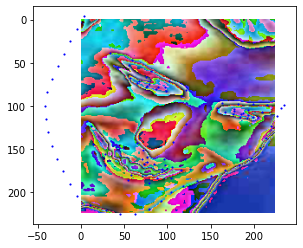

In [14]:
plt.figure()
sample = train_dataset[3000]
show_landmarks(sample['image'], sample['landmarks'])
plt.show()

# CelebA

In [19]:
train_dataset = CelebaDataset(data_loc + 'landmarks_train.csv', data_loc + 'attr_train.csv', data_loc + 'images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))
val_dataset = CelebaDataset(data_loc + 'landmarks_val.csv', data_loc + 'attr_val.csv', data_loc + 'images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))
test_dataset = CelebaDataset(data_loc + 'landmarks_test.csv', data_loc + 'attr_test.csv', data_loc + 'images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))

In [5]:
plt.figure()
sample = train_dataset[2000]
show_landmarks(sample['image'], sample['landmarks'])
plt.show()

ValueError: cannot reshape array of size 195 into shape (2)

<Figure size 432x288 with 0 Axes>

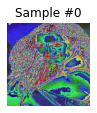

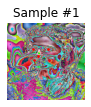

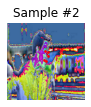

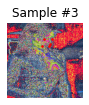

In [7]:
fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(sample['image'], sample['landmarks'])

    if i == 3:
        plt.show()
        break

In [14]:
num_classes = 10

resnet18 = models.resnet18(pretrained=False)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, num_classes)
resnet18 = resnet18.to(device)

In [6]:
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer, num_classes, print_every=100):
    size = len(dataloader.dataset)
    running_loss = 0.0
    for batch, data in enumerate(dataloader):
        model.train()
        
        X = data['image'].to(device)
        y = data['landmarks'].view(-1, num_classes).to(device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch % print_every == print_every - 1:    # print every 100 mini-batches
            print(f'Epoch: {epoch + 1}, batch: {batch + 1}, loss: {running_loss / print_every}')
            running_loss = 0.0

In [ ]:
writer = SummaryWriter('runs/celeba_resnet_experiment_1')
sample = iter(trainloader).next()
writer.add_graph(resnet18, sample['images'])

In [11]:
criterion = nn.MSELoss()
optimizer_args = {
    'lr': 1e-3,
    'weight_decay': 0,
}

num_epochs = 5

optimizer = optim.Adam(resnet18.parameters(), **optimizer_args)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n-----------------------------')
    train_loop(trainloader, resnet18, criterion, optimizer, num_classes)

Epoch 1
-----------------------------


RuntimeError: stack expects each tensor to be equal size, but got [3, 261, 128] at entry 0 and [3, 353, 267] at entry 1

tensor([[0.4927, 0.2660],
        [0.6317, 0.2778],
        [0.5707, 0.3300],
        [0.4805, 0.3838],
        [0.5927, 0.3923]])
tensor([[0.4658, 0.2821],
        [0.5947, 0.2584],
        [0.5696, 0.3557],
        [0.4897, 0.3987],
        [0.5840, 0.3822]], device='cuda:0', grad_fn=<ViewBackward>)


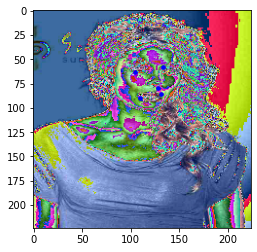

In [62]:
pred_num = 5

pred_landmarks = resnet18(train_dataset[pred_num]['image'].unsqueeze(0).to(device)).view(5, 2)
print(train_dataset[pred_num]['landmarks'])
print(pred_landmarks)
show_landmarks(train_dataset[pred_num]['image'], pred_landmarks.detach().cpu())